# CIFAR-10 dataset classification with CNNs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

170498071/170498071 [==============================] - 4s 0us/step


This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the images directly to the model.
    - The two Conv2D layers below learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

![conv layer](https://github.com/mcmeiers/ai-science-training-series/blob/main/03_neural_networks_tensorflow/images/conv_layer.png?raw=1)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](https://github.com/mcmeiers/ai-science-training-series/blob/main/03_neural_networks_tensorflow/images/conv.png?raw=1)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)


<img src="https://github.com/mcmeiers/ai-science-training-series/blob/main/03_neural_networks_tensorflow/images/MaxpoolSample2.png?raw=1" width="600" hight="600" align="left"/>

In [3]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [4]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [5]:
# This took 43 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/3
98/98 [==============================] - 164s 2s/step - loss: 1.7523 - accuracy: 0.3632
Epoch 2/3
98/98 [==============================] - 152s 2s/step - loss: 1.3983 - accuracy: 0.4983
Epoch 3/3
98/98 [==============================] - 152s 2s/step - loss: 1.2698 - accuracy: 0.5527


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

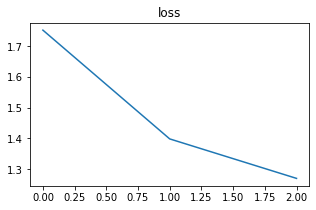

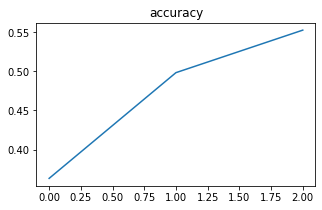

In [6]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 96.53%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). 

In [7]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 8s - loss: 1.1250 - accuracy: 0.6071 - 8s/epoch - 25ms/step
accuracy: 60.71%
CPU times: user 14.1 s, sys: 253 ms, total: 14.3 s
Wall time: 7.89 s


We can also again check the confusion matrix

In [8]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 9s 28ms/step
[[648  13  90  28  10  11  24  10 131  35]
 [ 40 672   8  26   6  11  22  10  66 139]
 [ 69   3 497  63  64 138 106  34  15  11]
 [ 12   6  95 444  40 239 105  31  13  15]
 [ 28   5 181  81 395  58 157  77  16   2]
 [ 11   1  95 183  34 578  33  52   9   4]
 [  3   2  61  79  26  25 787   8   3   6]
 [ 19   1  41  63  45 123  23 659   6  20]
 [ 92  44  24  27   3  17  16   5 736  36]
 [ 40  96  13  28   7  19  35  35  72 655]]

Classification accuracy for each class:

0: 0.6480
1: 0.6720
2: 0.4970
3: 0.4440
4: 0.3950
5: 0.5780
6: 0.7870
7: 0.6590
8: 0.7360
9: 0.6550


### More verbose training

This approach explicitly handles the looping over data. It will be helpful in future weeks for diving in and optimizing

In [9]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [10]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [11]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [12]:
def train_network(_batch_size, _n_training_epochs, _lr):

    cifar_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, cifar_model, opt)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 142.4 seconds for epoch #0
beginning epoch 1
took 142.5 seconds for epoch #1
beginning epoch 2
took 143.0 seconds for epoch #2


# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning rate, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.06%, although it varies randomly.

In [24]:
batch_size = 64
epochs = 10
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/10
782/782 [==============================] - 177s 226ms/step - loss: 1.6201 - accuracy: 0.4084
Epoch 2/10
782/782 [==============================] - 168s 214ms/step - loss: 1.2970 - accuracy: 0.5384
Epoch 3/10
782/782 [==============================] - 166s 212ms/step - loss: 1.1689 - accuracy: 0.5840
Epoch 4/10
782/782 [==============================] - 164s 210ms/step - loss: 1.0859 - accuracy: 0.6156
Epoch 5/10
782/782 [==============================] - 165s 211ms/step - loss: 1.0102 - accuracy: 0.6399
Epoch 6/10
782/782 [==============================] - 164s 210ms/step - loss: 0.9622 - accuracy: 0.6599
Epoch 7/10
782/782 [==============================] - 169s 216ms/step - loss: 0.9066 - accuracy: 0.6765
Epoch 8/10
782/782 [==============================] - 166s 212ms/step - loss: 0.8604 - accuracy: 0.6926
Epoch 9/10
782/782 [==============================] - 164s 210ms/step - loss: 0.8208 - accuracy: 0.7069
Epoch 10/10
782/782 [==============================] - 165s 212m

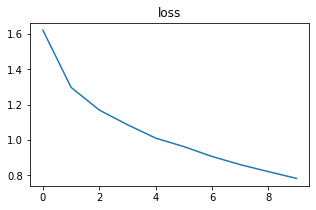

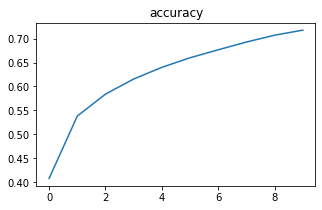

In [25]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [26]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 8s - loss: 0.8706 - accuracy: 0.6994 - 8s/epoch - 26ms/step
accuracy: 69.94%
CPU times: user 14.8 s, sys: 369 ms, total: 15.2 s
Wall time: 8.62 s


The classificatio accuracy increased from 58.06% to 79.59%